In [26]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision
import random
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
random.seed(42)
torch.manual_seed(42)

In [2]:

torch.cuda.is_available()

True

In [3]:
transform=T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0,std=1)
])
original_datasets=datasets.MNIST(root="./original_data",transform=transform,download=True,train=True)

original_dataloader=torch.utils.data.DataLoader(original_datasets,batch_size=64,drop_last=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.69MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.58MB/s]


In [10]:
class Generator(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Generator, self).__init__()
        self.downconv1=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3,padding=1),#
            torch.nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),#
            torch.nn.MaxPool2d(kernel_size=2,stride=1)
        )

        self.rock_bottom=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1),#
            torch.nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1),#
            torch.nn.MaxPool2d(kernel_size=2,stride=1)
        )

        self.upconvtranspose1=torch.nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,padding=1)

        self.upconv1=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128,out_channels=64,kernel_size=3,padding=1),
            torch.nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1),
        )

        self.out=torch.nn.ConvTranspose2d(in_channels=64,out_channels=out_channels,kernel_size=4,padding=1)
        self.tanh=torch.nn.Tanh()

    def forward(self,x):
        down_1=self.downconv1(x)
        bottle_neck=self.rock_bottom(down_1)

        up_1=self.upconvtranspose1(bottle_neck)

        up_1=self.upconv1(torch.cat([down_1,up_1],dim=1))

        return self.tanh(self.out(up_1))


In [11]:
# Surrogate model to mimic victim's model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.max_pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(64 * 7 * 7, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

surrogate_model=Net()

In [12]:
p=0.07
prune_rate=0.6
eta=10/255
lambda_l2=0.02
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
surrogate=surrogate_model.to(device)
noise_generator=Generator(in_channels=1,out_channels=1).to(device)

NG_optimizer=torch.optim.SGD(noise_generator.parameters(),lr=0.001)

surrogate_optimizer=torch.optim.SGD(surrogate.parameters(),lr=0.01)

CE=torch.nn.CrossEntropyLoss()

In [13]:
# surrogate model - the noise generator
# victim model - the clean model that the victim will use
def prune_model(model,rate=prune_rate,test=False):
    if test:
        victim_model=Net()
        new_model=victim_model.to(device)
    else:
        new_model=surrogate_model.to(device)
    new_model.load_state_dict(model.state_dict())
    parameters_to_prune=[]
    for name, module in new_model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.l1_unstructured(module,name='weight',amount=rate)

    return new_model

In [14]:
# trains the surrogate model without the noise
import torch.nn.functional as F
from tqdm import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in tqdm(original_dataloader,total=len(original_dataloader)):

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        y_pred = surrogate(batch_x)

        surrogate_loss = CE(y_pred, batch_y)
        surrogate_optimizer.zero_grad()
        surrogate_loss.backward()
        surrogate_optimizer.step()
        epoch_loss += surrogate_loss.item()

    print(f"Epoch {epoch} | Total epoch loss: {epoch_loss:.4f}")


100%|██████████| 937/937 [00:13<00:00, 71.05it/s]


Epoch 0 | Total epoch loss: 1047.7521


100%|██████████| 937/937 [00:13<00:00, 70.83it/s]


Epoch 1 | Total epoch loss: 281.2834


100%|██████████| 937/937 [00:13<00:00, 71.60it/s]


Epoch 2 | Total epoch loss: 195.3704


100%|██████████| 937/937 [00:12<00:00, 72.17it/s]


Epoch 3 | Total epoch loss: 147.1919


100%|██████████| 937/937 [00:13<00:00, 71.82it/s]


Epoch 4 | Total epoch loss: 118.4148


100%|██████████| 937/937 [00:13<00:00, 71.54it/s]


Epoch 5 | Total epoch loss: 99.5321


100%|██████████| 937/937 [00:13<00:00, 71.61it/s]


Epoch 6 | Total epoch loss: 86.5116


100%|██████████| 937/937 [00:13<00:00, 72.05it/s]


Epoch 7 | Total epoch loss: 76.8439


100%|██████████| 937/937 [00:13<00:00, 71.89it/s]


Epoch 8 | Total epoch loss: 69.4495


100%|██████████| 937/937 [00:13<00:00, 71.56it/s]

Epoch 9 | Total epoch loss: 63.4251


In [15]:
# first the surrogate model learns the classification normally. Then the noise generator learns to produce perturbations.
# finds the poison samples (top 2 diff)
# poison labels are changed to second highest predicted class
# prunes the surrogate
num_epochs=10
# pruned_surrogate=prune_model(surrogate)
for epoch in range(num_epochs):
    total_ng_loss = 0.0
    total_pruned_poison_loss=0.0
    total_surrogate_loss=0.0
    for s_x, s_y in tqdm(original_dataloader):

        # Loading data to cuda
        s_x = s_x.to(device)
        s_y = s_y.to(device)

        # Finding datapoints with less difference in probablity between top two
        # these will be the most easy to poison when diff is minimal
        scores = surrogate(s_x).detach()
        s_y_top2 = torch.topk(scores, k=2, dim=1)
        s_y_top2_diff = s_y_top2.values[:,0] - s_y_top2.values[:,1]
        sorted_idx = torch.argsort(s_y_top2_diff)

        # Taking k datapoints (i.e p percent of data ) with least difference as poison data and assigning p_y as 2nd class rather than first
        k = int(len(s_x) * p)
        p_x = s_x[sorted_idx[:k]]
        # p_y_original=s_x[sorted_idx[:k]]
        p_y_original=s_y[sorted_idx[:k]]
        p_y = s_y_top2.indices[sorted_idx[:k], 1]

        #Clean dataset contains remaining points
        clean_x = s_x[sorted_idx[k:]]
        clean_y = s_y[sorted_idx[k:]]

        s_x_mix = torch.concat([clean_x, p_x])
        s_y_mix = torch.concat([clean_y, p_y])

        #Generating noise on p_x,clean_x,s_x
        p_x_noisy = p_x + eta * noise_generator(p_x)
        clean_x_noisy = clean_x + eta * noise_generator(clean_x)
        s_x_noisy=s_x_mix+eta*noise_generator(s_x_mix)

        #Finding surrogate_loss
        surrogate_loss=CE(surrogate(clean_x),clean_y)+CE(surrogate(p_x_noisy),p_y_original)

        surrogate_optimizer.zero_grad()
        surrogate_loss.backward(retain_graph=True)
        surrogate_optimizer.step()

        total_surrogate_loss+=surrogate_loss.item()
        #Pruning surrogate model
        pruned_surrogate=prune_model(surrogate)

        l2_norm = eta * lambda_l2 * sum(p.pow(2).sum() for p in noise_generator.parameters())

        # pruned surrogate should missclassify the noisy label, correctly label the clean data and when unpruned, it should not missclassify (-ve)
        ng_loss =  CE(pruned_surrogate(p_x_noisy), p_y) + CE(pruned_surrogate(clean_x_noisy), clean_y) + CE(surrogate(p_x_noisy), p_y_original) + CE(surrogate(clean_x_noisy),clean_y)+l2_norm

        # total_pruned_poison_loss+=CE(pruned_surrogate(p_x_noisy), p_y).item()
        # ng_loss = CE(surrogate(s_x_noisy), s_y_mix)+CE(pruned_surrogate(clean_x_noisy), clean_y)+CE(pruned_surrogate(p_x_noisy), p_y)+ l2_norm

        NG_optimizer.zero_grad()
        ng_loss.backward(retain_graph=True)
        NG_optimizer.step()

        total_pruned_poison_loss+=CE(pruned_surrogate(p_x_noisy), p_y).item()
        total_ng_loss += ng_loss.item()


    print(f"Epoch [{epoch+1}/{num_epochs}] | Avg surrogate loss: {total_surrogate_loss/len(original_dataloader)}|Avg epoch Loss: {total_ng_loss/len(original_dataloader):.4f}|Pruned poison loss:{total_pruned_poison_loss/len(original_dataloader):.4f}")


100%|██████████| 937/937 [00:33<00:00, 27.83it/s]


Epoch [1/10] | Avg surrogate loss: 4.592874759702825|Avg epoch Loss: 9.3562|Pruned poison loss:2.2791


100%|██████████| 937/937 [00:32<00:00, 28.42it/s]


Epoch [2/10] | Avg surrogate loss: 4.603484160872126|Avg epoch Loss: 9.3608|Pruned poison loss:2.2729


100%|██████████| 937/937 [00:33<00:00, 28.32it/s]


Epoch [3/10] | Avg surrogate loss: 4.603473640938579|Avg epoch Loss: 9.3567|Pruned poison loss:2.2694


100%|██████████| 937/937 [00:32<00:00, 28.43it/s]


Epoch [4/10] | Avg surrogate loss: 4.603477232738645|Avg epoch Loss: 9.3555|Pruned poison loss:2.2687


100%|██████████| 937/937 [00:33<00:00, 28.21it/s]


Epoch [5/10] | Avg surrogate loss: 4.603477922803946|Avg epoch Loss: 9.3549|Pruned poison loss:2.2686


100%|██████████| 937/937 [00:33<00:00, 28.15it/s]


Epoch [6/10] | Avg surrogate loss: 4.6034780434127045|Avg epoch Loss: 9.3543|Pruned poison loss:2.2686


100%|██████████| 937/937 [00:33<00:00, 28.28it/s]


Epoch [7/10] | Avg surrogate loss: 4.603478062750817|Avg epoch Loss: 9.3538|Pruned poison loss:2.2686


100%|██████████| 937/937 [00:33<00:00, 28.18it/s]


Epoch [8/10] | Avg surrogate loss: 4.6034780815800325|Avg epoch Loss: 9.3532|Pruned poison loss:2.2686


100%|██████████| 937/937 [00:33<00:00, 28.08it/s]


Epoch [9/10] | Avg surrogate loss: 4.603478083106726|Avg epoch Loss: 9.3527|Pruned poison loss:2.2686


100%|██████████| 937/937 [00:33<00:00, 27.93it/s]

Epoch [10/10] | Avg surrogate loss: 4.603478084633419|Avg epoch Loss: 9.3522|Pruned poison loss:2.2686


In [16]:
torch.cuda.empty_cache()

In [17]:
noise_generator.eval()
surrogate.eval()

all_scores = []
all_x = []
all_y = []

for x, y in original_dataloader:
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        scores = surrogate(x).detach().cpu()

    all_scores.append(scores)
    all_x.append(x.cpu())
    all_y.append(y.cpu())

scores = torch.cat(all_scores)
s_x = torch.cat(all_x)
s_y = torch.cat(all_y)

print(scores.size())
s_y_top2 = torch.topk(scores, k=2, dim=1)
s_y_top2_diff = s_y_top2.values[:,0] - s_y_top2.values[:,1]
sorted_idx = torch.argsort(s_y_top2_diff)

k = int(len(s_x) * p)
torch.cuda.empty_cache()
P_x = s_x[sorted_idx[:k]]
P_y = s_y_top2.indices[sorted_idx[:k], 1]

C_x = s_x[sorted_idx[k:]]
C_y = s_y[sorted_idx[k:]]


P_pois_x = []
noise_generated=[]
for p_x in tqdm(P_x):
    p_x=p_x.to(device)
    torch.cuda.empty_cache()
    with torch.no_grad():
        noise = noise_generator(p_x.unsqueeze(0))
    generated_x = p_x + eta * noise.squeeze(0)
    generated_x = torch.clamp(generated_x, -1, 1)
    P_pois_x.append(generated_x.detach().cpu())
    noise_generated.append(noise.squeeze(0).detach().cpu())

P_pois_x = torch.stack(P_pois_x)
track_p_data=list(zip(sorted_idx[:k],P_x,s_y[sorted_idx[:k]],P_y))
# S_pois= poisoned + clean dataset
S_pois = list(zip(C_x, C_y)) + list(zip(P_pois_x, P_y))


torch.Size([59968, 10])


100%|██████████| 4197/4197 [00:03<00:00, 1164.76it/s]


In [18]:
import torch
from torch.utils.data import Subset, DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

# Suppose your dataset is:
features, labels = zip(*S_pois)
features = torch.stack(features)
labels = torch.stack(labels)

train_dataset = TensorDataset(features, labels)
val_dataset=datasets.MNIST(root="./test_data",download=True,train=False,transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]

Train size: 59968, Val size: 10000


In [19]:
clean_victim_model=Net()

clean_victim=clean_victim_model.to(device)

In [20]:
optimizer=torch.optim.SGD(clean_victim.parameters(),lr=0.01)

CE=torch.nn.CrossEntropyLoss()

In [21]:
import torch.nn.functional as F
from tqdm import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in tqdm(original_dataloader,total=len(train_loader)):

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        y_pred = clean_victim(batch_x)

        loss = CE(y_pred, batch_y)
        loss.backward()
        optimizer.step()


        epoch_loss += loss.item()
    # scheduler.step()
    print(f"Epoch {epoch} | Loss: {epoch_loss:.4f}")


100%|██████████| 937/937 [00:13<00:00, 71.69it/s]


Epoch 0 | Loss: 1218.5191


100%|██████████| 937/937 [00:12<00:00, 72.45it/s]


Epoch 1 | Loss: 296.1766


100%|██████████| 937/937 [00:12<00:00, 72.68it/s]


Epoch 2 | Loss: 209.4277


100%|██████████| 937/937 [00:12<00:00, 72.66it/s]


Epoch 3 | Loss: 158.3829


100%|██████████| 937/937 [00:12<00:00, 73.07it/s]


Epoch 4 | Loss: 125.9863


100%|██████████| 937/937 [00:12<00:00, 73.05it/s]


Epoch 5 | Loss: 104.5395


100%|██████████| 937/937 [00:12<00:00, 72.49it/s]


Epoch 6 | Loss: 89.6901


100%|██████████| 937/937 [00:12<00:00, 73.23it/s]


Epoch 7 | Loss: 78.9388


100%|██████████| 937/937 [00:12<00:00, 72.52it/s]


Epoch 8 | Loss: 70.7870


100%|██████████| 937/937 [00:12<00:00, 73.09it/s]

Epoch 9 | Loss: 64.2479


In [22]:
def test_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    true_labels=[]
    pred_labels=[]
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            true_labels.extend(batch_y.detach().cpu())
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item() * batch_x.size(0)

            _, predicted = torch.max(outputs, 1)
            pred_labels.extend(predicted.detach().cpu())
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total

    print(f"Test Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
    return true_labels,pred_labels

true_victim_labels,pred_victim_labels=test_model(clean_victim_model,val_loader,CE,device)

Test Loss: 0.0738 | Accuracy: 97.75%


In [23]:
pruned_clean_victim_model=prune_model(clean_victim_model,rate=prune_rate,test=True)
true_victim_pruned_labels,pred_pruned_victim_labels=test_model(pruned_clean_victim_model,val_loader,CE,device)

Test Loss: 0.1012 | Accuracy: 97.01%


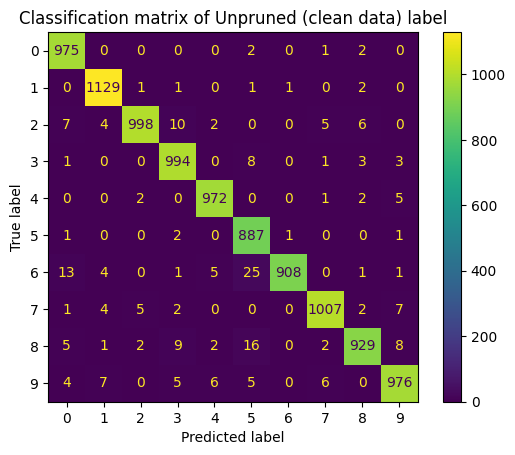

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_victim_labels, pred_victim_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Classification matrix of Unpruned (clean data) label")
plt.show()


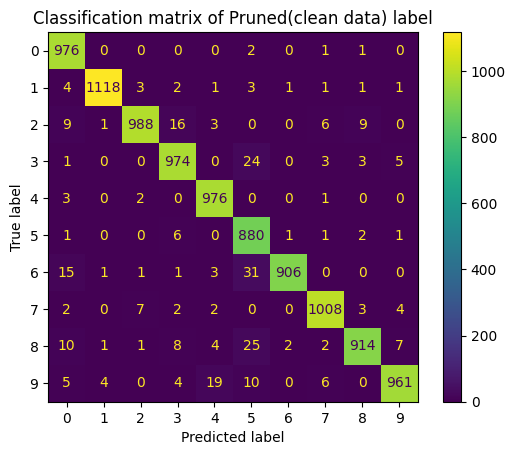

In [27]:
cm = confusion_matrix(true_victim_pruned_labels, pred_pruned_victim_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Classification matrix of Pruned(clean data) label")
plt.show()

In [28]:
poisoned_victim_model=Net()

posion_victim=poisoned_victim_model.to(device)


In [29]:
optimizer=torch.optim.SGD(posion_victim.parameters(),lr=0.01)

CE=torch.nn.CrossEntropyLoss()

In [30]:
import torch.nn.functional as F
from tqdm import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in tqdm(train_loader,total=len(train_loader)):

        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        y_pred = posion_victim(batch_x)

        loss = CE(y_pred, batch_y)
        loss.backward()
        optimizer.step()


        epoch_loss += loss.item()
    # scheduler.step()
    print(f"Epoch {epoch} | Loss: {epoch_loss:.4f}")


100%|██████████| 937/937 [00:02<00:00, 407.49it/s]


Epoch 0 | Loss: 1203.5449


100%|██████████| 937/937 [00:02<00:00, 398.85it/s]


Epoch 1 | Loss: 511.5554


100%|██████████| 937/937 [00:02<00:00, 411.17it/s]


Epoch 2 | Loss: 428.9709


100%|██████████| 937/937 [00:02<00:00, 408.54it/s]


Epoch 3 | Loss: 379.7301


100%|██████████| 937/937 [00:02<00:00, 410.71it/s]


Epoch 4 | Loss: 348.8408


100%|██████████| 937/937 [00:02<00:00, 411.51it/s]


Epoch 5 | Loss: 328.1354


100%|██████████| 937/937 [00:02<00:00, 406.74it/s]


Epoch 6 | Loss: 312.7977


100%|██████████| 937/937 [00:02<00:00, 410.78it/s]


Epoch 7 | Loss: 301.3307


100%|██████████| 937/937 [00:02<00:00, 401.59it/s]


Epoch 8 | Loss: 288.4864


100%|██████████| 937/937 [00:02<00:00, 415.14it/s]

Epoch 9 | Loss: 279.4005


In [31]:
true_victim_labels,pred_victim_labels=test_model(posion_victim,val_loader,CE,device)

Test Loss: 0.1374 | Accuracy: 97.61%


In [32]:
pruned_poison_victim_model=prune_model(posion_victim,rate=prune_rate,test=True)

In [33]:
true_labels,pred_labels=test_model(pruned_poison_victim_model,val_loader,CE,device)

Test Loss: 0.4029 | Accuracy: 85.56%


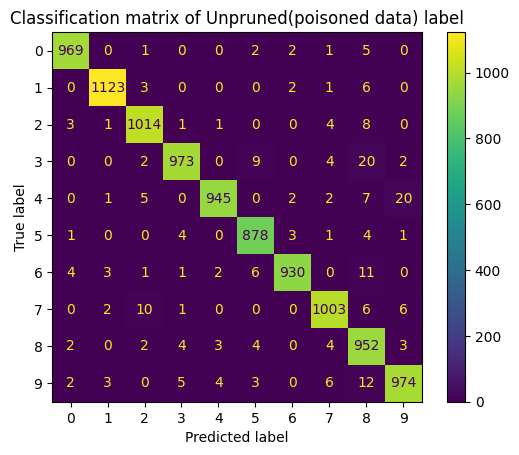

In [34]:
cm = confusion_matrix(true_victim_labels, pred_victim_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Classification matrix of Unpruned(poisoned data) label")
plt.show()

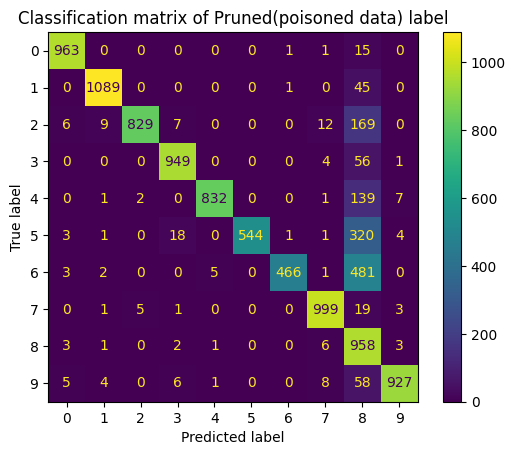

In [35]:
cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.title("Classification matrix of Pruned(poisoned data) label")
plt.show()

In [36]:
misclassified_labels = [(idx,i)  for  idx,i in enumerate(list(zip(pred_victim_labels,pred_labels))) if i[0]!=i[1]]

In [37]:
misclassified_labels

[(8, (tensor(5), tensor(8))),
 (21, (tensor(6), tensor(8))),
 (43, (tensor(2), tensor(8))),
 (96, (tensor(1), tensor(8))),
 (119, (tensor(2), tensor(8))),
 (130, (tensor(6), tensor(8))),
 (149, (tensor(2), tensor(8))),
 (151, (tensor(9), tensor(8))),
 (153, (tensor(5), tensor(8))),
 (155, (tensor(5), tensor(8))),
 (156, (tensor(6), tensor(8))),
 (164, (tensor(6), tensor(8))),
 (182, (tensor(5), tensor(8))),
 (187, (tensor(5), tensor(3))),
 (191, (tensor(1), tensor(8))),
 (193, (tensor(9), tensor(8))),
 (195, (tensor(3), tensor(8))),
 (219, (tensor(5), tensor(8))),
 (241, (tensor(9), tensor(8))),
 (244, (tensor(2), tensor(8))),
 (247, (tensor(2), tensor(8))),
 (250, (tensor(4), tensor(8))),
 (261, (tensor(5), tensor(8))),
 (267, (tensor(1), tensor(8))),
 (289, (tensor(5), tensor(8))),
 (290, (tensor(4), tensor(8))),
 (300, (tensor(4), tensor(8))),
 (304, (tensor(4), tensor(8))),
 (314, (tensor(1), tensor(8))),
 (317, (tensor(5), tensor(8))),
 (318, (tensor(2), tensor(3))),
 (320, (tenso

In [38]:
len(misclassified_labels)

1341

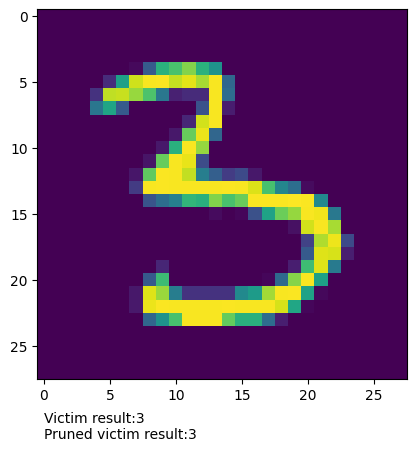

In [39]:
import matplotlib.pyplot as plt
plt.imshow(val_dataset[313][0][0])
plt.text(0,32,s=f'Victim result:{pred_victim_labels[313]}\nPruned victim result:{pred_labels[313]}',)
plt.show()